In [1]:
import os
import json
import math
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import torch
import random
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from torch.utils.data import DataLoader, TensorDataset
import optuna

In [2]:
def set_seeds(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

In [3]:
warnings.filterwarnings('ignore')
%matplotlib inline

In [4]:
df = pd.read_excel("../datasets/Tesla_Stock.xlsx")
df = df.drop(columns=["Unnamed: 0"], errors="ignore")
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)
df = df[["Close"]]
df = df.iloc[-2000:]

train_size = int(len(df) * 0.8)
df_train_raw = df.iloc[:train_size]
df_test_raw = df.iloc[train_size:]

scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(df_train_raw)
scaled_test = scaler.transform(df_test_raw)

In [5]:
def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

In [6]:
X_train, y_train = create_sequences(scaled_train)
X_test, y_test = create_sequences(scaled_test)

X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1)
X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(-1)

In [7]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return x

In [8]:
class TransformerTimeSeries(nn.Module):
    def __init__(self, feature_size=1, d_model=64, nhead=2, num_layers=1, dropout=0.1):
        super().__init__()
        self.input_linear = nn.Linear(feature_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        encoder_layers = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        self.decoder = nn.Linear(d_model, 1)

    def forward(self, src):
        x = self.input_linear(src)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        out = self.decoder(x[:, -1, :])
        return out

device = torch.device("cpu")

In [9]:
def evaluate(model, loader, scaler):
    model.eval()
    preds = []
    actuals = []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            pred = model(xb).cpu().numpy()
            preds.append(pred)
            actuals.append(yb.numpy())
    preds = np.vstack(preds)
    actuals = np.vstack(actuals)
    preds_inv = scaler.inverse_transform(preds)
    actuals_inv = scaler.inverse_transform(actuals)
    rmse = math.sqrt(mean_squared_error(actuals_inv, preds_inv))
    return preds_inv, actuals_inv, rmse

In [10]:
def objective(trial):
    set_seeds()

    # Hyperparameter search space
    d_model = trial.suggest_categorical('d_model', [32, 64, 128])
    nhead = trial.suggest_categorical('nhead', [2, 4, 8])
    num_layers = trial.suggest_int('num_layers', 1, 4)
    dropout = trial.suggest_float('dropout', 0.05, 0.3)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])

    # Model and training components
    model = TransformerTimeSeries(d_model=d_model, nhead=nhead, num_layers=num_layers, dropout=dropout).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

    # Proper train/val split BEFORE wrapping into TensorDataset
    val_ratio = 0.1
    val_size = int(len(X_train) * val_ratio)
    train_size = len(X_train) - val_size

    X_train_actual = X_train[:train_size]
    y_train_actual = y_train[:train_size]
    X_val = X_train[train_size:]
    y_val = y_train[train_size:]

    train_dataset = TensorDataset(X_train_actual, y_train_actual)
    val_dataset = TensorDataset(X_val, y_val)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Early stopping parameters
    early_stopping_patience = 5
    best_val_loss = float('inf')
    epochs_no_improve = 0
    max_epochs = 50

    for epoch in range(max_epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        model.eval()
        val_losses = []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                pred = model(xb)
                loss = criterion(pred, yb)
                val_losses.append(loss.item())
        val_loss = sum(val_losses) / len(val_losses)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= early_stopping_patience:
            break

    return best_val_loss

In [11]:
set_seeds(42)

sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='minimize', sampler=sampler)
study.optimize(objective, n_trials=25)
best_params = study.best_params

[I 2025-05-26 11:42:33,332] A new study created in memory with name: no-name-5d21139a-d6a8-4845-a704-4fbc53f8d0de
[I 2025-05-26 11:43:26,018] Trial 0 finished with value: 0.0029922183603048325 and parameters: {'d_model': 64, 'nhead': 2, 'num_layers': 1, 'dropout': 0.2665440364437338, 'lr': 0.0015930522616241021, 'batch_size': 64}. Best is trial 0 with value: 0.0029922183603048325.
[I 2025-05-26 11:46:40,566] Trial 1 finished with value: 0.0020842717106764517 and parameters: {'d_model': 32, 'nhead': 8, 'num_layers': 2, 'dropout': 0.12280728504951048, 'lr': 0.0016738085788752138, 'batch_size': 64}. Best is trial 1 with value: 0.0020842717106764517.
[I 2025-05-26 11:50:50,295] Trial 2 finished with value: 0.0012990497518330813 and parameters: {'d_model': 64, 'nhead': 4, 'num_layers': 3, 'dropout': 0.09263103092182289, 'lr': 0.00013492834268013249, 'batch_size': 32}. Best is trial 2 with value: 0.0012990497518330813.
[I 2025-05-26 11:51:21,552] Trial 3 finished with value: 0.00270092923892

In [12]:
batch_size = best_params['batch_size']
model = TransformerTimeSeries(
    d_model=best_params['d_model'],
    nhead=best_params['nhead'],
    num_layers=best_params['num_layers'],
    dropout=best_params['dropout']
).to(device)

criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'])
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=1e-5)

In [13]:
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

max_epochs = 50  # Set to a reasonable fixed value

print("Starting final training on full training data...")

for epoch in range(max_epochs):
    model.train()
    epoch_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        epoch_loss += loss.item() * xb.size(0)
    epoch_loss /= len(train_loader.dataset)

    print(f"Epoch {epoch+1}/{max_epochs} Train Loss: {epoch_loss:.6f}")

# No model.load_state_dict() — we're training fully without early stopping

Starting final training on full training data...
Epoch 1/50 Train Loss: 0.038917
Epoch 2/50 Train Loss: 0.004274
Epoch 3/50 Train Loss: 0.003327
Epoch 4/50 Train Loss: 0.002944
Epoch 5/50 Train Loss: 0.002397
Epoch 6/50 Train Loss: 0.002242
Epoch 7/50 Train Loss: 0.002199
Epoch 8/50 Train Loss: 0.001785
Epoch 9/50 Train Loss: 0.002510
Epoch 10/50 Train Loss: 0.001592
Epoch 11/50 Train Loss: 0.001550
Epoch 12/50 Train Loss: 0.001552
Epoch 13/50 Train Loss: 0.001389
Epoch 14/50 Train Loss: 0.001492
Epoch 15/50 Train Loss: 0.001156
Epoch 16/50 Train Loss: 0.001217
Epoch 17/50 Train Loss: 0.001277
Epoch 18/50 Train Loss: 0.001071
Epoch 19/50 Train Loss: 0.001163
Epoch 20/50 Train Loss: 0.001270
Epoch 21/50 Train Loss: 0.001018
Epoch 22/50 Train Loss: 0.001052
Epoch 23/50 Train Loss: 0.001142
Epoch 24/50 Train Loss: 0.000968
Epoch 25/50 Train Loss: 0.001120
Epoch 26/50 Train Loss: 0.001112
Epoch 27/50 Train Loss: 0.000917
Epoch 28/50 Train Loss: 0.000998
Epoch 29/50 Train Loss: 0.001047
Epo

In [14]:
train_pred_inv, y_train_inv, train_rmse = evaluate(model, train_loader, scaler)
print(f"Train RMSE: {train_rmse:.4f}")

Train RMSE: 7.8019


In [17]:
pred_path = "predictions/Stock_Transformer_train.npy"
os.makedirs("predictions", exist_ok=True)
np.save(pred_path, train_pred_inv)

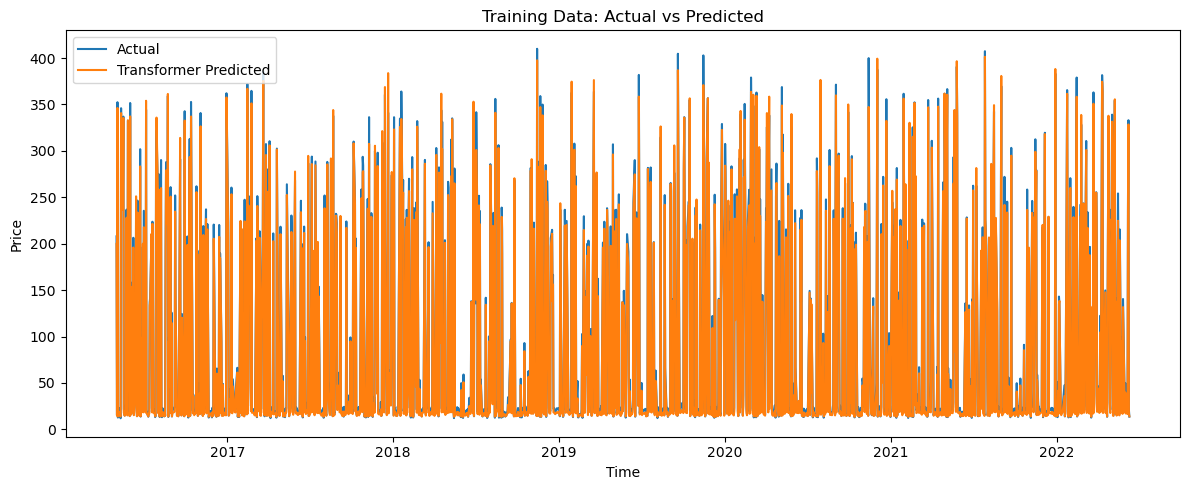

In [15]:
plt.figure(figsize=(12, 5))
plt.plot(df_train_raw.index[-len(train_pred_inv):], y_train_inv, label='Actual')
plt.plot(df_train_raw.index[-len(train_pred_inv):], train_pred_inv, label='Transformer Predicted')
plt.title('Training Data: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
test_pred_inv, y_test_inv, test_rmse = evaluate(model, test_loader, scaler)
print(f"Test RMSE: {test_rmse:.4f}")

Test RMSE: 10.5055


In [18]:
dataset_name = "Stock"
rmse_file = "RMSE_Transformer.json"
try:
    with open(rmse_file, "r") as f:
        rmse_data = json.load(f)
except FileNotFoundError:
    rmse_data = {}

rmse_data[dataset_name] = round(test_rmse, 2)
with open(rmse_file, "w") as f:
    json.dump(rmse_data, f, indent=4)

In [19]:
pred_path = "predictions/Stock_Transformer_test.npy"
os.makedirs("predictions", exist_ok=True)
np.save(pred_path, test_pred_inv)

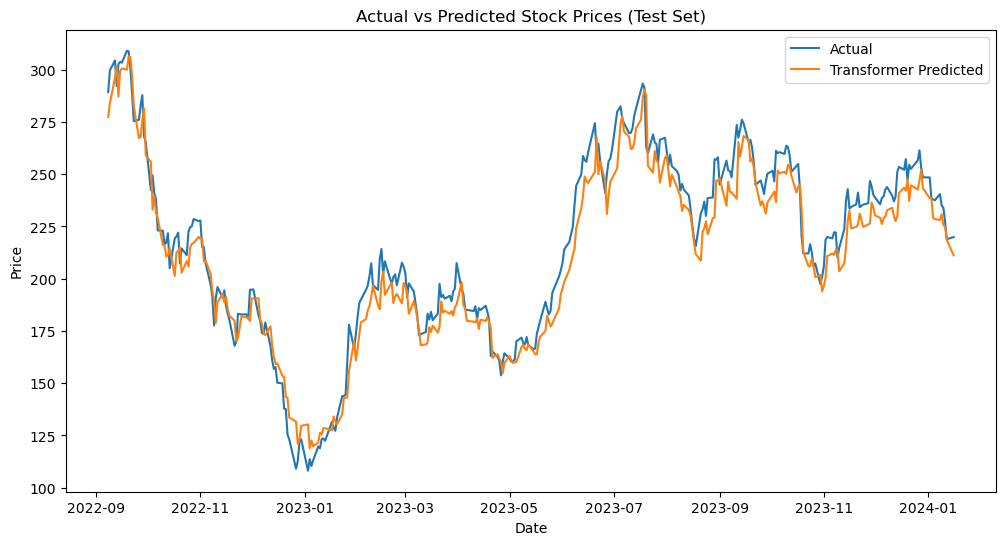

In [20]:
plt.figure(figsize=(12,6))
plt.plot(df_test_raw.index[-len(test_pred_inv):], y_test_inv, label='Actual')
plt.plot(df_test_raw.index[-len(test_pred_inv):], test_pred_inv, label='Transformer Predicted')
plt.title('Actual vs Predicted Stock Prices (Test Set)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()